# Reproduction of: 
## *"ALBERTA’S FISCAL RESPONSES TO FLUCTUATIONS IN NON-RENEWABLE-RESOURCE REVENUE"*
## in python

This notebook attempts to replicate the empirical results, tables, and figures produced in the paper by Ergete Ferede, published by the University of Calgary school of public policy in Volume 11:24, September 2018.
The original paper is here: [https://www.policyschool.ca/wp-content/uploads/2018/09/NRR-Ferede.pdf](https://www.policyschool.ca/wp-content/uploads/2018/09/NRR-Ferede.pdf)

## Setup and data acquisition

This section of the code loads required modules, downloads the required data sets, and reads them into DataFrames

In [1]:
from pathlib import Path
import datetime as dt
import requests
import pandas as pd
import numpy as np
import stats_can
import altair as alt
import seaborn as sns
%matplotlib inline

In [2]:
def download_data():
    """Download the excel file for the analysis from the policy school page
    
    Note the readme sheet on the first file. Credit to Kneebone and Wilkins for
    assembling it, and policy school for hosting it
    
    Returns
    -------
    fname: pathlib.Path
        A path object with the location and name of the data
    """
    print('Downloading data set')
#     url = 'https://www.policyschool.ca/wp-content/uploads/2019/01/Provincial-Government-Budget-Data-January-2019FINAL-USE.xlsx'
    url = 'https://www.policyschool.ca/wp-content/uploads/2019/03/Provincial-Government-Budget-Data-March-2019.xlsx'
    response = requests.get(
        url,
        stream=True,
        headers={'user-agent': None}
    )
    fname = Path('.').joinpath('data').joinpath('budgets.xlsx')
    with open (fname, 'wb') as outfile:
        for chunk in response.iter_content(chunk_size=512):
            if chunk: # filter out keep-alive new chunks
                outfile.write(chunk)
    return fname

def get_file(force_update=False):
    """Return the data set, download if necessary"""
    fname = Path('.').joinpath('data').joinpath('budgets.xlsx')
    if not fname.exists() or force_update:
        download_data()
    return fname


def get_date_index(df):
    """Helper function to turn budget year strings into datetimes"""
    date_index = pd.to_datetime(
        df
        .assign(year=lambda df: df['budget_yr'].str[0:4].astype(int))
        .assign(month=1)
        .assign(day=1)
        [['year', 'month', 'day']]
    )
    return date_index


def read_ab_budget():
    """Read Alberta budget data 
    
    Downloads the data if necessary, reads it in and gives
    the variables easier to work with names
    
    Returns
    -------
    df: pandas.DataFrame
        Alberta's revenue and expenditure tables
    """
    fname = get_file()
    df = (
        pd.read_excel(
            fname,
            sheet_name='Alberta',
            header=3,
            index_col=1,
            skipfooter=21
        )
        # Because of the merged cells we get an empty first row
        .loc[lambda x: x.index.notnull()]
        # Not sure where the empty first column comes from but drop it
        .drop(columns='Unnamed: 0')
        .reset_index()
        .rename(columns={
            'index': 'budget_yr',
            'Personal Income Tax': 'personal_income_tax',
            'Corporation Income Tax': 'corporate_income_tax',
            'Retail Sales Tax': 'retail_sales_tax',
            'Federal Cash Transfers': 'federal_cash_transfers',
            'Natural Resource Revenue': 'natural_resource_revenue',
            'Other Own-Source Revenue': 'other_own_source_revenue',
            'Total Revenue': 'total_revenue',
            'Health': 'health_exp',
            'Social Services': 'social_services_exp',
            'Education': 'education_exp',
            'Other Program Expenditures': 'other_program_exp',
            'Total Program Expenditures': 'total_prog_exp',
            'Debt Service': 'debt_service',
            'Total  Expenditures': 'total_exp',
            'Unnamed: 16': 'annual_deficit'
        })
        .assign(budget_dt=lambda df: get_date_index(df))
        .set_index('budget_dt')
    )  
    return df

def read_heritage():
    """Heritage Trust fund deposits are separate"""
    fname = get_file()
    df = (
        pd.read_excel(
            fname,
            sheet_name='Alberta',
            header=None,
            usecols='D:G',
            names=['budget_yr', 'resource_allocation', 'deposits', 'advance_edu'],
            skiprows=71,
            skipfooter=1
        )
        .loc[lambda df: ~df['budget_yr'].isna()]
        .set_index('budget_yr')
        .fillna(0)
        .assign(total_heritage=lambda df: df.sum(axis='columns'))
        # Add a dummy variable to indicate heritage fund deposit years
        .assign(heritage_dummy=1)
        .reset_index()
        .assign(budget_dt=lambda df: get_date_index(df))
        .drop(columns='budget_yr')
        .set_index('budget_dt')
    )
    return df


def clean_budget():
    """Combine base budget with heritage deposits"""
    budg = read_ab_budget()
    heritage= read_heritage()
    budg_clean = (
        budg
        .assign(other_revenue=lambda df: df[['retail_sales_tax', 'federal_cash_transfers', 'other_own_source_revenue']].sum(axis='columns'))
        .reindex(columns=['personal_income_tax', 'corporate_income_tax', 'natural_resource_revenue', 'other_revenue', 'total_prog_exp', 'debt_service'])
        .merge(heritage[['total_heritage', 'heritage_dummy']], how='left', left_index=True, right_index=True)
        .fillna(0)
        .assign(natural_resource_revenue_before_heritage=lambda df: df['natural_resource_revenue'])
        .assign(natural_resource_revenue=lambda df: df['natural_resource_revenue'] - df['total_heritage'])
        .assign(total_revenue=lambda df: df[['personal_income_tax', 'corporate_income_tax', 'natural_resource_revenue', 'other_revenue']].sum(axis='columns'))
        .assign(total_expenditure=lambda df: df[['total_prog_exp', 'debt_service']].sum(axis='columns'))
        .assign(deficit=lambda df: df['total_expenditure'] - df['total_revenue'])
        .astype('float64')
    )
    return budg_clean


def per_capita_data():
    """Read in population data to calculate per capita estimates
    
    Rolling mean indexed on January year N+1 is the March to March
    average population for fiscal year N
    Applying a date offset of -1 year and taking only
    January data of these rolling means gives us a population average
    on the same basis as the fiscal tables
    """
    table = '17-10-0009-01'
    df = (
        stats_can.table_to_df(table, path='data')
        .loc[lambda x: x['GEO'] == 'Alberta']
        .loc[lambda x: x['REF_DATE'] >= '1965']
        .set_index('REF_DATE')
        [['VALUE']]
        .rename(columns={'VALUE':'population'})
        .rolling(4, closed='left')
        .mean()
        .reset_index()
        .assign(budget_dt=lambda df: df['REF_DATE'] - pd.DateOffset(years=1))
        .loc[lambda x: x['budget_dt'].dt.year >= 1965]
        .loc[lambda x: x['budget_dt'].dt.month == 1]
        .drop(columns='REF_DATE')
        .set_index('budget_dt')
        .copy()
    )
    return df


def inflation_data():
    """Read in inflation data to calculate real dollar estimates
    
    Rolling mean indexed on January year N+1 is the March to March
    average population for fiscal year N
    Applying a date offset of -1 year and taking only
    January data of these rolling means gives us an average on the
    same basis as the budget dates. The whole series is then scaled so
    2017 budget year is = 1
    """
    vecs = ('v41692327', 'v41690973')
    df = (
        stats_can.vectors_to_df_local(vecs, path='data', start_date=dt.date(1965, 1, 1))
        .rename(columns={'v41692327': 'ab_inflation', 'v41690973': 'ca_inflation'})
    )
    mask = df['ab_inflation'].isna()
    df.loc[mask, 'ab_inflation'] = df.loc[mask, 'ca_inflation']
    df = (
        df
        .drop(columns='ca_inflation')
        .rolling(4, closed='left')
        .mean()
        .reset_index()
        .assign(budget_dt=lambda df: df['REF_DATE'] - pd.DateOffset(years=1))
        .loc[lambda x: x['budget_dt'].dt.year >= 1965]
        .loc[lambda x: x['budget_dt'].dt.month == 1]
        .drop(columns='REF_DATE')
        .set_index('budget_dt')
        .copy()
    )
    # Rescale to 2017 = 100 (this is fiscal year 2017, original may have done calendar year)
    inf_2017 = float(df.loc['2017', 'ab_inflation'])
    df = df / inf_2017
    return df


def budget_real_per_capita():
    """Take total current dollar budget results
    and covert them to per capital constant 2017 dollars
    """
    clean_budget_df = clean_budget()
    scale_cols = clean_budget_df.columns.drop('heritage_dummy').tolist()
    per_capita = per_capita_data()
    inflation = inflation_data()
    dfpc = (
        clean_budget_df
        .assign(pop=per_capita)
        .assign(cpi=inflation)
    )
    dfpc[scale_cols] = (
        dfpc[scale_cols]
        .mul(1_000_000)
        .div(dfpc['pop'], axis='index')
        .div(dfpc['cpi'], axis='index')
    )
    return dfpc

def exogenous_variables():
    """Bring in exogenous parameters
    
    From the paper:
    We also include other exogenous variables that are likely to affect
    the province’s budget. It is known that the various components of the
    provincial budget can be influenced by the business cycle. Thus, following
    Buettner and Wildsain (2006), we account for the potential effects of the
    business cycle by including one-period lagged changes in the provincial
    employment and unemployment rates. Another important exogenous factor
    that is often cited in provincial budget documents as being important in
    influencing the provincial government’s oil royalty revenue is the Canadian-U.S.
    dollar exchange rate. For this reason, we control for this factor by
    including oneperiod lagged changes in the Canadian-U.S. dollar exchange rate
    
    Currency data sourced from: https://fred.stlouisfed.org/series/EXCAUS
    """
    ur_vec = "v2064516"
    er_vec = "v2064518"
    cad_usd = (
        pd.read_csv('./data/EXCAUS.csv', parse_dates=['DATE'])
        .set_index('DATE')
    )
    return "working on this section"


In [3]:
df = budget_real_per_capita()

## Exploratory Figures

### Figure 1
Page 5 of the report charts Non-renewable Resource Revenue, Total Expenditure, and Total Revenue. All are in per-capita 2017 dollars.
Reproducing this chart will be a good starting check that my data extraction and transformation matches the original author's strategy

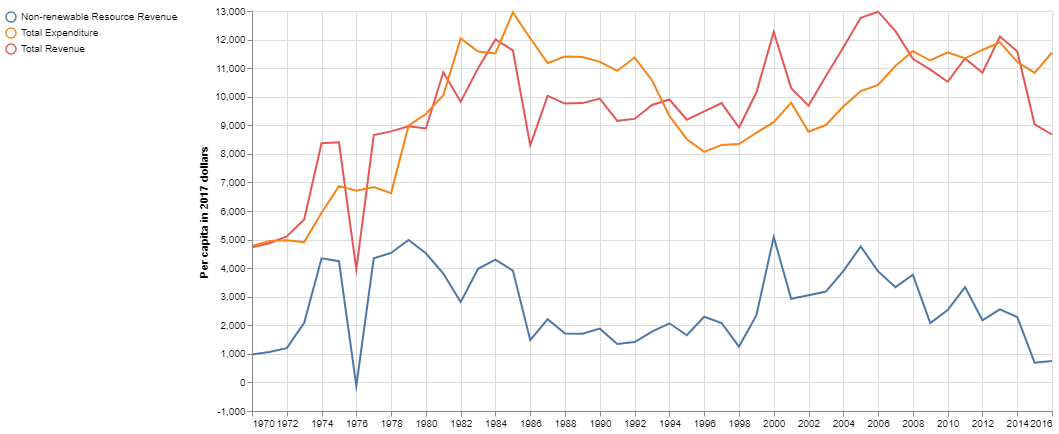

In [4]:
chart_df = (
    df
    .loc['1970':'2016', ['natural_resource_revenue', 'total_revenue', 'total_expenditure']]
    .rename(columns={
        'natural_resource_revenue': 'Non-renewable Resource Revenue',
        'total_revenue': 'Total Revenue',
        'total_expenditure': 'Total Expenditure'
    })
    .reset_index()
    .melt(id_vars='budget_dt')
)
chart = (
    alt.Chart(chart_df)
    .mark_line()
    .encode(
        x=alt.X('budget_dt:T', axis=alt.Axis(title=None)),
        y=alt.Y('value:Q', axis=alt.Axis(title='Per capita in 2017 dollars')),
        color=alt.Color('variable:N', legend=alt.Legend(title=None, orient='left'))
    )
    .properties(width=800, height=400)
)
chart

This graph looks very similar to the chart in the paper, with a notable exception of the 1976/1977 budget year. My chart shows Non-renewable Resource Revenue as slightly negative, whereas the original chart has it largely in line with 1975/1976 and 1977/1978. NRR is negative in my chart because I have netted out contributions to the Alberta Heritage Savings Trust Fund (AHSTF). To the best of my understanding, the original paper does the same, and the consistent values between the two in all other years supports that. Quoting the original paper:

>The part of resource revenue that is saved in the AHSTF is not expected to influence the provincial government’s spending and revenue-raising choices. For this reason, in our analysis, we exclude the part of the resource revenue that is saved in the AHSTF from the non-renewable-resource revenue data. 

For comparison, here is the same chart, but without netting AHSTF contributions:

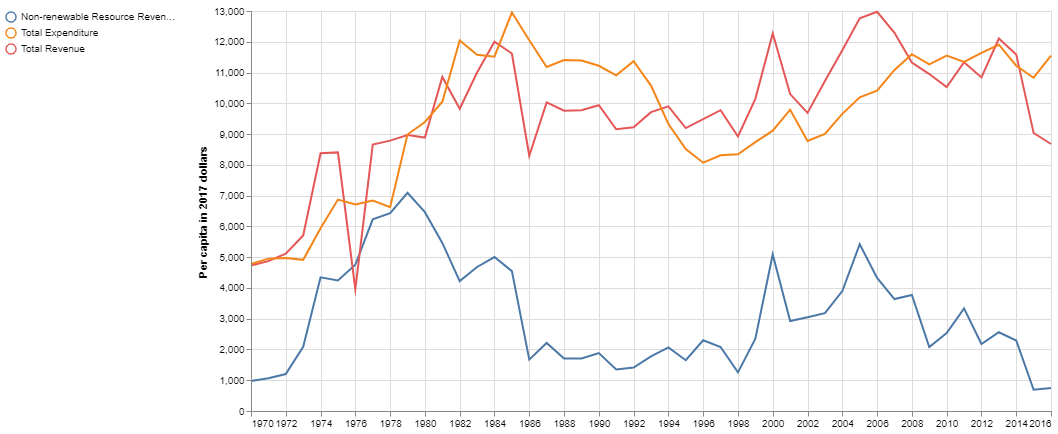

In [5]:
chart_df = (
    df
    .loc['1970':'2016', ['natural_resource_revenue_before_heritage', 'total_revenue', 'total_expenditure']]
    .rename(columns={
        'natural_resource_revenue_before_heritage': 'Non-renewable Resource Revenue (before AHSTF contributions)',
        'total_revenue': 'Total Revenue',
        'total_expenditure': 'Total Expenditure'
    })
    .reset_index()
    .melt(id_vars='budget_dt')
)
chart = (
    alt.Chart(chart_df)
    .mark_line()
    .encode(
        x=alt.X('budget_dt:T', axis=alt.Axis(title=None)),
        y=alt.Y('value:Q', axis=alt.Axis(title='Per capita in 2017 dollars')),
        color=alt.Color('variable:N', legend=alt.Legend(title=None, orient='left'))
    )
    .properties(width=800, height=400)
)
chart

1976/1977 more closely matches the original chart in the paper, but the remaining years in the period of mid 70s to mid 80s when there were significant contributions clearly do not match. Going forward all analysis in this reproduction will treat NRR as net of AHSTF contributions.

### Figure 2

Page 6 of the paper produces a scatter plot of Real per capita non-renewable resource revenue on the X axis vs. Real per capita budget balance on the Y, along with a linear trend fit.

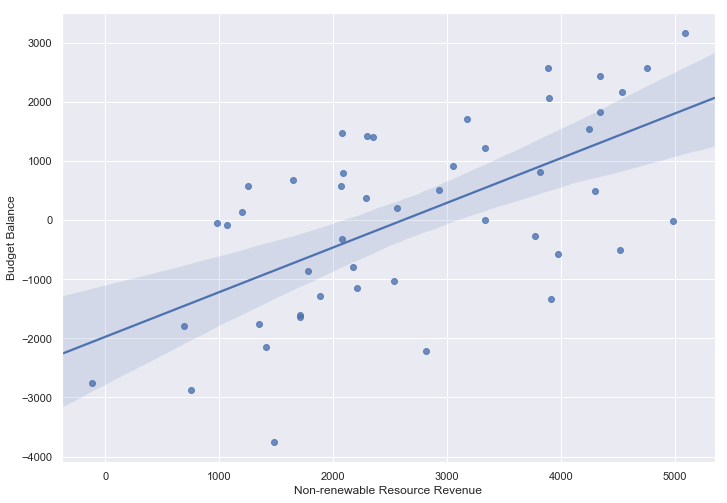

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
chart_df = (
    df
    .loc['1970':'2016', ['natural_resource_revenue', 'deficit']]
    .rename(columns={
        'natural_resource_revenue': 'Non-renewable Resource Revenue',
        'deficit': 'Deficit'
    })
    .assign(balance=lambda df: df['Deficit'] * -1)
    .rename(columns={'balance': 'Budget Balance'})
    .copy()
)
sns.regplot(x='Non-renewable Resource Revenue', y='Budget Balance', data=chart_df)

With the exception of the outlier previously noted in the time series view of the plot, this representation also looks very similar to what was in the original paper.